In [40]:
import numpy as np
import pickle
import zipfile
import tempfile
from typing import List, Optional, Tuple
from pathlib import Path
from cgmml.common.depthmap_toolkit.constants import EXTRACTED_DEPTH_FILE_NAME
from cgmml.common.depthmap_toolkit.depthmap import Depthmap
from PIL import Image
from matplotlib import pyplot as plt
from cgmml.common.background_segmentation.deeplab.deeplab_model import get_deeplab_model, PERSON_SEGMENTATION

In [41]:
## add the cgm-ml repo location in case imports through error

import sys

sys.path.append('../../cgm-ml-copy')

In [42]:
DEEPLAB_MODEL = get_deeplab_model()

In [43]:
def extract_depthmap(depthmap_fpath: str, dest_dir: str) -> Path:
    """Extract depthmap from given file"""
    with zipfile.ZipFile(Path(depthmap_fpath), 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    return Path(dest_dir) / EXTRACTED_DEPTH_FILE_NAME

In [44]:
def read_depthmap_data(depthmap_fpath):
    with tempfile.TemporaryDirectory() as tmpdirname:
        path = extract_depthmap(depthmap_fpath, tmpdirname)
        with open(path, 'rb') as f:
            header_line = f.readline().decode().strip()
            width, height, depth_scale, max_confidence, device_pose = Depthmap.parse_header(header_line)
            data = f.read()
            f.close()
    return width, height, data, depth_scale, max_confidence, device_pose, header_line

## segmentation map extraction for sample image

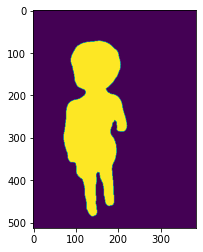

In [46]:
from matplotlib import pyplot as plt
rgb_file = '../feature_analysis/scans/cef7be21-b99d-11ed-a07e-1f06179fe4a4/rgb/4.jpg'
im = Image.open(rgb_file).rotate(-90, expand=True)
im.save('rotated_image.jpg')
plt.imshow(im)
resized_im, seg_map = DEEPLAB_MODEL.run(im)
plt.imshow(seg_map)
# resized_im = resized_im.resize(new_size)
plt.imshow(seg_map)
person = seg_map[seg_map == PERSON_SEGMENTATION]

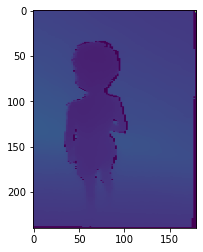

In [47]:
depthmap_file = '../feature_analysis/scans/cef7be21-b99d-11ed-a07e-1f06179fe4a4/depth/4.zip' # your depthmap location
calibration_file = '../feature_analysis/scans/cef7be21-b99d-11ed-a07e-1f06179fe4a4/calibration/0' # your calibration location
dmap = Depthmap.create_from_zip_absolute(depthmap_file, 0, calibration_file)
# dmap.resize(seg_map.shape[0], seg_map.shape[1])
depthmap = dmap.depthmap_arr
plt.imshow(depthmap)

## Code to create dataset in pickle format

In [ ]:
import os
import glob
from PIL import Image
import cv2
import numpy as np
import pickle
import random

# Define the folder paths
scan_folder = 'scans/'

NEW_SIZE = (180, 240)


# Get the list of subfolders in the scan folder
subfolders = glob.glob(os.path.join(scan_folder, '*'))

# Iterate over the subfolders
for subfolder in subfolders:
    # Get the scan_id from the subfolder path
    scan_id = os.path.basename(subfolder)
    
    # Get the list of depthmap files in the current subfolder
    depthmap_files = glob.glob(os.path.join(subfolder, 'depth', '*.zip'))
    
    # Get the list of segmentation map files in the current subfolder
#     segmap_files = glob.glob(os.path.join(subfolder, 'segmap', '*.png'))
    
    rgb_files = glob.glob(os.path.join(subfolder, 'rgb', '*.jpg'))
    # Create the pickle folder if it doesn't exist
    pickle_folder = os.path.join(subfolder, 'pickle')
    os.makedirs(pickle_folder, exist_ok=True)
    
    # Iterate over the depthmap and segmentation map files
    for depthmap_file, rgb_file in zip(depthmap_files, rgb_files):
        # Load and process the depthmap
        dmap = Depthmap.create_from_zip_absolute(depthmap_file, 0, calibration_file)
        depthmap = dmap.depthmap_arr
        
        # Load rgb image and create segmentation map
        im = Image.open(rgb_file).rotate(-90, expand=True)
        resized_im, seg_map = DEEPLAB_MODEL.run(im)
        numpy_array = seg_map.astype(np.uint8)
        segmap = Image.fromarray(numpy_array)
        segmap = segmap.resize(NEW_SIZE)
        
        resized_im = resized_im.resize(NEW_SIZE)
        segmap_shape = (segmap.size[1],segmap.size[0])
        # Check if the dimensions of segm_arr and depthmap are the same
        if segmap_shape != depthmap.shape:
            # Print error message and skip processing the file
            print(f"Error: Segmentation map and depthmap dimensions do not match for file '{segmap_file}'. Skipping file.")
            continue
        
        # Expand the dimensions of the depthmap array to match the shape of the segmentation array
        expanded_depthmap_arr = np.expand_dims(depthmap, axis=2)
        segm_arr = np.expand_dims(segmap, axis=2)
        resized_im = np.array(resized_im)
        # Concatenate the depthmap and segmentation map arrays
        
#         concatenated_arr = np.concatenate((expanded_depthmap_arr,resized_im ,segm_arr), axis=2)
        
        # Create the dictionary with 'height' key and a random number between 90 and 100
        data_dict = {'height': random.uniform(90, 100)}
        
        # Get the file name of the depthmap zip file
        depthmap_filename = os.path.basename(depthmap_file)
        
        # Define the output pickle file path
        output_file = os.path.join(pickle_folder, depthmap_filename.replace('.zip', '.p'))
        
        # Save the concatenated array and the dictionary in the pickle file
        with open(output_file, 'wb') as f:
            pickle.dump([expanded_depthmap_arr,resized_im ,segm_arr, data_dict], f)


## Visualising the output pickle

Height: 96.58208748912823


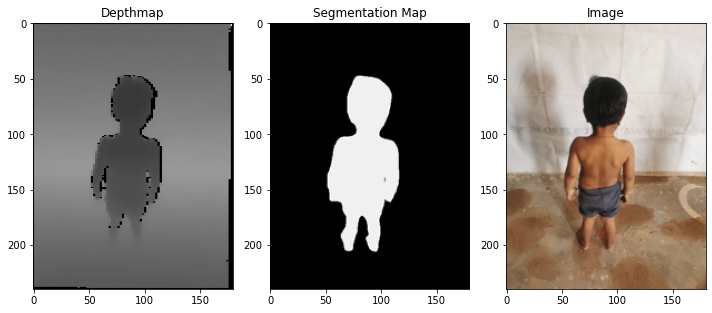

In [49]:
pickle_file = 'scans/d1093900-b99d-11ed-a07e-c784d64acc4f/pickle/2.p'

# Load the pickle file
with open(pickle_file, 'rb') as f:
    data = pickle.load(f)

# Access the concatenated array, depthmap, and segmentation
depthmap = data[0]
segm_arr = data[2]
image = data[1]

# Access the height value
height = data[3]['height']

# Visualize the depthmap and segmentation
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(depthmap, cmap='gray')
axs[0].set_title('Depthmap')
axs[1].imshow(segm_arr, cmap='gray')
axs[1].set_title('Segmentation Map')
axs[2].imshow(image)
axs[2].set_title('Image')

# Display the height value
print(f"Height: {height}")

# Show the plots
plt.tight_layout()
plt.show()


## overlay of segmentation on top of depthmap 

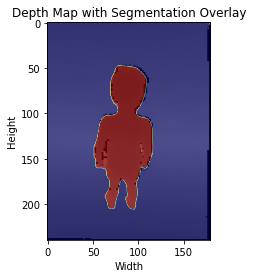

In [52]:
import matplotlib.pyplot as plt

# Assuming you have the image stored in the 'image' variable

# Split the image into the depth map and segmentation map
depth_map = depthmap
segmentation_map = segm_arr

# Create a figure and axes
fig, ax = plt.subplots()

# Display the depth map
ax.imshow(depth_map, cmap='gray')

# Overlay the segmentation map with alpha blending
ax.imshow(segmentation_map, cmap='jet', alpha=0.5)

# Set the title and labels
ax.set_title('Depth Map with Segmentation Overlay')
ax.set_xlabel('Width')
ax.set_ylabel('Height')

# Show the plot
plt.show()


## Depthmap 

In [54]:
import glob
import pickle
import tensorflow as tf

In [55]:
dataset_path = 'scans'
# dataset_path = os.path.join('.', "scans")
print('Dataset path: %s', dataset_path)
#logger.info(glob.glob(os.path.join(dataset_path, "*"))) # Debug
print('Getting QR-code paths...')
qrcode_paths = glob.glob(os.path.join(dataset_path, "*"))
print('qrcode_paths: %d', len(qrcode_paths))

Dataset path: %s scans
Getting QR-code paths...
qrcode_paths: %d 8


## model

In [56]:
def get_depthmap_files(paths):
    pickle_paths = []
    for path in paths:
        pickle_paths.extend(glob.glob(os.path.join(path,'pickle', "*.p")))
    return pickle_paths

In [57]:
paths_training = get_depthmap_files(qrcode_paths)


In [ ]:
depthmap,rgb,segmap,targets = pickle.load(open(paths_training[0], "rb"))
plt.imshow(rgb)

In [ ]:
IMAGE_TARGET_HEIGHT =int(240)
IMAGE_TARGET_WIDTH = int(180)

## Putting data(depthmap and segmentmap , labels) in Numpy array for  training

In [18]:
# Iterate over the file paths
depth_maps = []
segmentation_maps = []
labels = []

for file_path in paths_training:
    # Load the pickle file
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Extract the data from the pickle file
    depth_map = data[0]
    segmentation_map = data[2]
    label = data[3]['height']
    
    # Append the data to the lists
    depth_maps.append(depth_map)
    segmentation_maps.append(segmentation_map)
    labels.append(label)

# Convert the lists to numpy arrays
depth_maps = np.array(depth_maps)
segmentation_maps = np.array(segmentation_maps)
labels = np.array(labels)

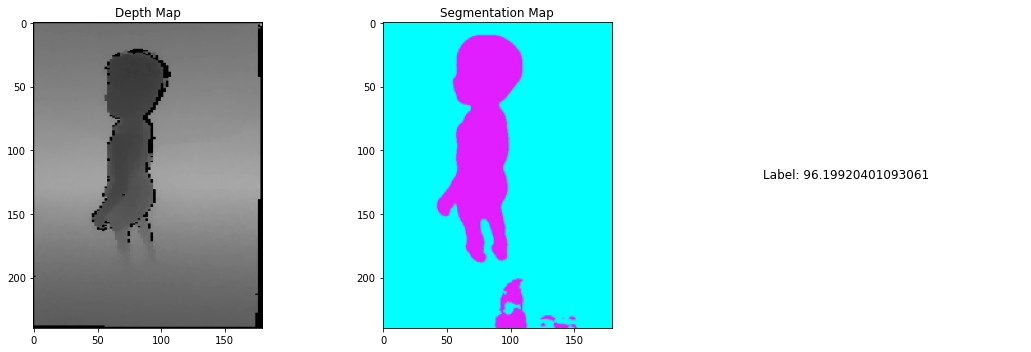

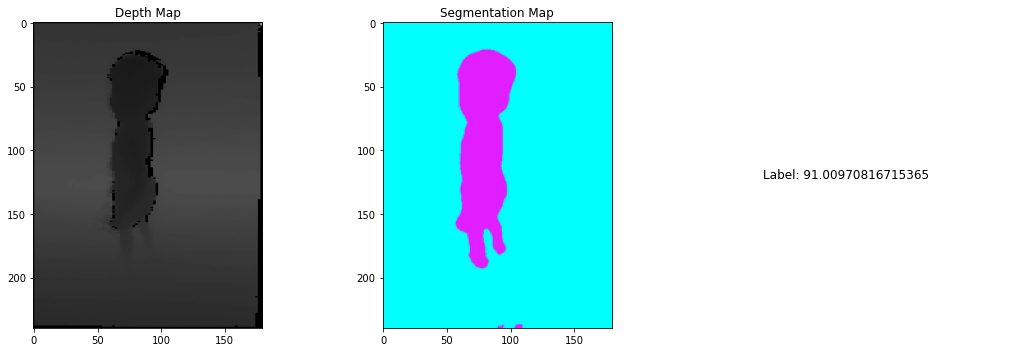

In [25]:
# Select only 2 samples for visualization
num_samples = 2
depth_maps = depth_maps[:num_samples]
segmentation_maps = segmentation_maps[:num_samples]
labels = labels[:num_samples]

# Iterate over the selected samples and visualize depth map, segmentation map, and labels
for i in range(num_samples):
    depth_map = depth_maps[i]
    segmentation_map = segmentation_maps[i]
    label = labels[i]
    
    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Visualize the depth map
    axs[0].imshow(depth_map, cmap='gray')
    axs[0].set_title('Depth Map')
    
    # Visualize the segmentation map
    axs[1].imshow(segmentation_map, cmap='cool')
    axs[1].set_title('Segmentation Map')
    
    # Visualize the label
    axs[2].text(0.5, 0.5, f"Label: {label}", fontsize=12, ha='center', va='center')
    axs[2].axis('off')
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    
    # Show the figure
    plt.show()

In [ ]:
## creating 

In [38]:
dataset = tf.data.Dataset.from_tensor_slices(((depth_maps, segmentation_maps), labels))
# Shuffle and batch the dataset
batch_size = 1
dataset = dataset.shuffle(buffer_size=num_samples)
dataset = dataset.batch(batch_size)

# Define a function to preprocess the dataset (if needed)
def preprocess_data(inputs, height):
    depth_map, segment_map = inputs
    # Apply any necessary preprocessing to the depth map, segment map, and height
    # You can use TensorFlow operations here
    return (depth_map, segment_map), height

# Apply the preprocessing function to the datasets
train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)


In [39]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_dataset, epochs=10, validation_data=val_dataset)


2023-06-19 11:10:25.915376: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_6/mul' id:5610 op device:{requested: '', assigned: ''} def:{{{node loss_6/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_6/mul/x, loss_6/dense_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-19 11:10:26.402490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2,240,180,1]
	 [[{{node Placeholder/_0}}]]
2023-06-19 11:10:26.402837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can i

Train on 1 steps
Epoch 1/10


2023-06-19 11:10:27.607064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [2,240,180,1]
	 [[{{node Placeholder/_1}}]]
2023-06-19 11:10:27.607403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2,240,180,1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 8523.0684

ValueError: Empty training data.

In [31]:
# Split the dataset into training and validation sets
train_size = int(0.8 * num_samples)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# our model

In [16]:
import tensorflow.keras as keras
from tensorflow.keras import layers

# tf.config.experimental_run_functions_eagerly(True)


# NewModel (replacing the first input branch)
input_shape = (240, 180, 1)
new_model = create_cnn(input_shape, dropout=True)

# Freeze the weights of NewModel to keep them fixed during training
for layer in new_model.layers:
    layer.trainable = False

# Extract the embedding from NewModel
new_model_embedding = new_model.layers[-4].output  # Assuming the embedding layer is the 4th layer from the end

# OGModel (second input branch)
input_shape = (240, 180, 1)
input2 = keras.Input(shape=input_shape)
conv1_1 = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(input2)
conv1_2 = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(conv1_1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1_2)
conv2_1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(pool1)
conv2_2 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(conv2_1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)
flatten2 = layers.Flatten()(pool2)
embedding2 = layers.Dense(64, activation='relu')(flatten2)

# Concatenate the embeddings from NewModel and OGModel
concatenated = layers.Concatenate()([new_model_embedding, embedding2])

# Additional layers after concatenation
hidden1 = layers.Dense(64, activation='relu')(concatenated)
hidden2 = layers.Dense(32, activation='relu')(hidden1)

# Output layer (single float value)
output = layers.Dense(1, activation='linear')(hidden2)

# Create the UpdatedModel with the modified input branch and one output
updated_model = keras.Model(inputs=[new_model.input, input2], outputs=output)

updated_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_20_input (InputLayer)   [(None, 240, 180, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 240, 180, 32  320         ['conv2d_20_input[0][0]']        
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 240, 180, 32  9248        ['conv2d_20[0][0]']              
                                )                                                           

 flatten_4 (Flatten)            (None, 43200)        0           ['max_pooling2d_17[0][0]']       
                                                                                                  
 dropout_14 (Dropout)           (None, 1024)         0           ['dense_8[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 64)           2764864     ['flatten_4[0][0]']              
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1088)         0           ['dropout_14[0][0]',             
                                                                  'dense_11[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 64)           69696       ['concatenate_1[0][0]']          
          

In [21]:
updated_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model using the entire dataset.
updated_model.fit([depth_maps, segmentation_maps], labels, validation_split=0.2, epochs=10, batch_size=32)


Train on 57 samples, validate on 15 samples
Epoch 1/10


2023-06-19 05:37:57.235284: W tensorflow/c/c_api.cc:300] Operation '{name:'total_3/Assign' id:3076 op device:{requested: '', assigned: ''} def:{{{node total_3/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_3, total_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


57/57 [==============================] - ETA: 0s - loss: 1649.4009 - mean_absolute_error: 29.4553

2023-06-19 05:37:59.231009: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_3/mul' id:3115 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_14_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


57/57 [==============================] - 2s 39ms/sample - loss: 1649.4009 - mean_absolute_error: 29.4553 - val_loss: 120.2766 - val_mean_absolute_error: 9.1113
Epoch 2/10
57/57 [==============================] - 2s 34ms/sample - loss: 258.7059 - mean_absolute_error: 14.3404 - val_loss: 1689.8557 - val_mean_absolute_error: 40.3466
Epoch 3/10
57/57 [==============================] - 2s 34ms/sample - loss: 1558.6812 - mean_absolute_error: 38.9757 - val_loss: 2023.2664 - val_mean_absolute_error: 44.3234
Epoch 4/10
57/57 [==============================] - 2s 34ms/sample - loss: 1531.4241 - mean_absolute_error: 38.6043 - val_loss: 1153.4825 - val_mean_absolute_error: 32.8175
Epoch 5/10
57/57 [==============================] - 2s 34ms/sample - loss: 533.7602 - mean_absolute_error: 21.6246 - val_loss: 258.2569 - val_mean_absolute_error: 12.6313
Epoch 6/10
57/57 [==============================] - 2s 34ms/sample - loss: 115.0443 - mean_absolute_error: 8.3183 - val_loss: 123.5112 - val_mean_absol